In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import warnings
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder

warnings.filterwarnings("ignore")

In [3]:
tabular_data = pd.read_csv("tabular_data.csv", sep=',')
hashed_feature = pd.read_csv("hashed_feature.csv", sep=',')
train = pd.read_csv("train.csv", sep=',')
test = pd.read_csv("test.csv", sep=',')

In [668]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion


def replace_df(df):
    x = df.copy()
    x[df.columns] = full_pipeline.fit_transform(df)[:, :]
    return x


def OneHotEncoder_features(x, names):
    lb_style : LabelBinarizer = LabelBinarizer()
    lb_results = lb_style.fit_transform(x[names])
    new_tabular_data =pd.concat( [x[['id']],
        pd.DataFrame(lb_results, columns=[f"{names}_{i}" for i in range(len(lb_style.classes_))])
    ], axis=1)
    
    return new_tabular_data.groupby(by=['id']).sum()


def OneHotEncoder_for_Hashed_data(data):
    x = np.array(data['feature_50'].value_counts()[:3].index)
    data.fillna(x[0], inplace=True)
    data['feature_50'] = data['feature_50'].astype('category')
    
    new_hashed_feature = data.groupby(by=['id']).count()
    new_hashed_feature['id'] = new_hashed_feature.index
    new_hashed_feature.index=pd.RangeIndex(0, new_hashed_feature.shape[0], 1)
    
    return new_hashed_feature
    
    
def union_with_target(df1, df2, df3, df4):
    df1_s = df1[[f'feature_{i}' for i in (list(range(0,25)) + list(range(26, 50)))]+['id']].groupby(by=['id']).sum()
    df2_s = df2.groupby(by=['id']).sum()
    
    df_2_s = pd.merge(df2_s, df3, how='inner', on='id')
    return pd.merge(pd.merge(df1_s, df_2_s, how='inner', on='id'), df4, how='inner', on='id')

def union_with_test(df1, df2, df3):
    df1_s = df1[[f'feature_{i}' for i in (list(range(0,25)) + list(range(26, 50)))]+['id']].groupby(by=['id']).sum()
    df2_s = df2.groupby(by=['id']).sum()
    
    df_2_s = pd.merge(df2_s, df3, how='inner', on='id')
    return pd.merge(df1_s, df_2_s, how='inner', on='id')
    
    
class DataFrameSelector (BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

class DataFrameCreator(BaseEstimator, TransformerMixin):
    def __init__(self, df: pd.DataFrame):
        self.df = df
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X) -> pd.DataFrame:
        tmp = self.df.copy()
        tmp[[f'feature_{i}' for i in (list(range(0,25)) + list(range(26, 50)))]] = X[:, :]
        return tmp

feature_pipeline = Pipeline([
    ("Selector", DataFrameSelector([f'feature_{i}' for i in (list(range(0,25)) + list(range(26, 50))) ])),
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy='median')),
    ('Scaler', StandardScaler()),
    ("CreatorDF", DataFrameCreator(tabular_data)),
])


full_pipeline = FeatureUnion(transformer_list=[
    ("feature", feature_pipeline),
])



1

In [745]:
full_data = union_with_target(
                        replace_df(tabular_data),
                        OneHotEncoder_features(tabular_data, "feature_25"),
                        OneHotEncoder_for_Hashed_data(hashed_feature),
                        train
)

sc = StandardScaler()
sc.fit(full_data[[f'feature_25_{i}' for i in range(0,8)]+["feature_50"]])

full_data[[f'feature_25_{i}' for i in range(0,8)]+["feature_50"]] = sc.fit_transform(full_data[[f'feature_25_{i}' for i in range(0,8)]+["feature_50"]])[:,:]

In [746]:
X, y = full_data[full_data.columns[1:-1]], full_data['target']

In [747]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import KernelPCA, PCA
from sklearn.neural_network import MLPClassifier

In [748]:
def get_roc_auc_score(model, X_valid, y_valid):
    return roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
    

In [759]:
"""
    Датасет
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y, train_size=.80)

In [760]:
extra = ExtraTreesClassifier(random_state=0, n_jobs=-1, n_estimators=800, max_leaf_nodes=150)

extra.fit(X_train, y_train)
get_roc_auc_score(extra, X_test, y_test)

0.7484509001004405

In [761]:
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier( max_depth=2 ) , n_estimators=250,
algorithm= "SAMME.R" , learning_rate=0.01)
ada_clf.fit( X_train , y_train )

get_roc_auc_score(ada_clf, X_test, y_test)

0.7382948311828788

In [ ]:
clf_pca_kernel = Pipeline(
    [("kpca", KernelPCA(n_components=10)),
    ("log_reg", LogisticRegression())]
)
param_grid = [
    {
        "kpca__gamma":np.linspace(0.03, 0.05, 10),
        "kpca__kernel":["rbf", "sigmoid"]
    }
]

pca_k = GridSearchCV(clf_pca_kernel, param_grid, cv=3, n_jobs=-1)
pca_k.fit(X_train, y_train)
roc_auc_score(y_test,pca_k.predict_proba(X_test)[:,1])

In [ ]:
final_model = grid_search.best_estimator_


get_roc_auc_score(final_model, X_test, y_test)
roc_auc_score(y_test, grid_search.predict(X_test))

In [ ]:
tree_cl = DecisionTreeClassifier(random_state=0, max_depth=5, max_features=10)
cross_val_score(tree_cl, X_train, y_train, cv=5).mean()
y_pred = cross_val_predict(tree_cl, X_train, y_train, cv=5)

confusion_matrix(y_train, y_pred)
precision_score(y_train, y_pred), recall_score(y_train, y_pred)

tree_cl.fit(X_train, y_train)
get_roc_auc_score(tree_cl, X_test, y_test)
roc_auc_score(y_test, tree_cl.predict(X_test))

In [ ]:
knn_first = KNeighborsClassifier(n_neighbors=20)
cross_val_score(knn_first, X_train, y_train, cv=5).mean()


y_pred = cross_val_predict(knn_first, X_train, y_train, cv=5)

confusion_matrix(y_train, y_pred)
precision_score(y_train, y_pred), recall_score(y_train, y_pred)
knn_first.fit(X_train, y_train)
get_roc_auc_score(knn_first, X_test, y_test)

In [ ]:
param_grid = [
    {
        'n_estimators': [3,10,20, 30, 50, 100],
        'max_features':[2, 4, 6, 8, 10, 12], "max_depth":[i for i in range(5, 20, 2)]
    },
    {
        'bootstrap':[False], "n_estimators":[3,6,8, 10], "max_features":[2,3,4, 6, 8, 10], "max_depth":[i for i in range(5, 16, 2)]
    }
]

#random_forest_cl = RandomForestClassifier(random_state=0, n_jobs=5, max_depth=15)
#random_forest_cl.fit(X_train, y_train)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_forest_cl = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500, max_leaf_nodes=16, criterion='entropy')
#random_forest_cl.fit(X_train, y_train)
#grid_search = GridSearchCV(random_forest_cl, param_grid, cv=5, scoring='roc_auc')
#grid_search.fit(X_train, y_train)
#final_model = grid_search.best_estimator_

#results  = cross_val_score(random_forest_cl, X_train, y_train, cv=skf)
#get_roc_auc_score(random_forest_cl, X_test, y_test)


parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20], "criterion":['gini', 'entropy']}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

get_roc_auc_score(gcv, X_test, y_test)
roc_auc_score(y_test, gcv.predict(X_test))

In [ ]:
roc_auc_score(y_test, gcv.predict(X_test))
#gcv.predict_proba(X_test)[:,1]

In [ ]:
grid_search.best_estimator_

In [ ]:
random_forest_cl.fit(X_train, y_train)
#y_probas_forest = cross_val_predict(random_forest_cl, X_train, y_train, cv=3, method="predict_proba")

#confusion_matrix(y_train, y_pred)
#precision_score(y_train, y_pred), recall_score(y_train, y_pred), f1_score(y_train, y_pred), get_roc_auc_score(final_model, X_test, y_test)

In [ ]:
#Logistic regression
lr = LogisticRegression(
    multi_class="multinomial", solver='lbfgs', C=.1,
    random_state=0)
lr.fit(X_train, y_train)
y_probas_log = cross_val_predict(lr, X_train, y_train, cv=3, method="predict_proba")
lr.score(X_test, y_test)
get_roc_auc_score(lr, X_test, y_test)
roc_auc_score(y_test, lr.predict(X_test))

In [644]:
#SVM
svm = LinearSVC(C=1.1, loss='hinge')
svm.fit(X_train, y_train)
y_probas_svm = cross_val_predict(svm, X_train, y_train, cv=3, method="decision_function")
svm.score(X_test, y_test)
roc_auc_score(y_test, svm.predict(X_test))

0.5882059800664452

In [645]:
svm_pol = SVC(kernel='poly', degree=3, coef0=5, C=.1, random_state=0)
svm_pol.fit(X_train, y_train)
y_probas_svm_poly = cross_val_predict(svm, X_train, y_train, cv=3, method="decision_function")
svm_pol.score(X_test, y_test)
roc_auc_score(y_test, svm_pol.predict(X_test))

0.5599667774086379

In [646]:
sgd_clf = SGDClassifier(loss='hinge',random_state=0)
sgd_clf.fit(X_train, y_train)
y_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")
#confusion_matrix(y_train, y_pred)
#precision_score(y_train, y_pred), recall_score(y_train, y_pred)
sgd_clf.score(X_test, y_test)
roc_auc_score(y_test, sgd_clf.predict(X_test))

0.6051495016611296

In [647]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr", lr), ("rf", random_forest_cl), ('svc', svm)
    ], voting='hard'#or soft if all models have predict_proba
)

voting_clf.fit(X_train, y_train)
roc_auc_score(y_test, voting_clf.predict(X_test))

0.5867109634551495

In [648]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=0), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=0
)

bag_clf.fit(X_train, y_train)
roc_auc_score(y_test, bag_clf.predict(X_test))

0.5862126245847176

In [262]:
def plot_recision_recall_vs_treshold(name, precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Точность')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Полнота')
    plt.xlabel("Порог")
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.title(name)
    plt.show()
    
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.legend(loc='lower right')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [404]:
#plot_recision_recall_vs_treshold("SGD",*precision_recall_curve(y_train, y_pred))
#plot_recision_recall_vs_treshold("RandomForest", *precision_recall_curve(y_train, y_probas_forest[:,1]))
#plot_recision_recall_vs_treshold("LogRegression", *precision_recall_curve(y_train, y_probas_log[:,1]))
#plot_recision_recall_vs_treshold("SVM",*precision_recall_curve(y_train, y_probas_svm))
#plot_recision_recall_vs_treshold("SVM",*precision_recall_curve(y_train, y_probas_svm_poly))

In [407]:
#fpr, tpr, thresholds = roc_curve(y_train, y_pred)
#plot_roc_curve(fpr, tpr, "SGD")

#fpr, tpr, thresholds = roc_curve(y_train, y_probas_forest[:,1])
#plot_roc_curve(fpr, tpr,  "RandomForest")

#fpr, tpr, thresholds = roc_curve(y_train, y_probas_log[:,1])
#plot_roc_curve(fpr, tpr,  "LogRegression")

#fpr, tpr, thresholds = roc_curve(y_train, y_probas_svm)
#plot_roc_curve(fpr, tpr,  "SVM")

#fpr, tpr, thresholds = roc_curve(y_train, y_probas_svm_poly)
#plot_roc_curve(fpr, tpr,  "SVM POL")

#roc_auc_score(y_train, y_probas_log[:,1]), roc_auc_score(y_train, y_probas_forest[:,1]), roc_auc_score(y_train, y_probas_svm), roc_auc_score(y_train, y_probas_svm_poly)

In [ ]:
# Создание полноценной модели

In [432]:
"""features_importances = random_forest_cl.feature_importances_
features_ = sorted(list(zip(features_importances, X.columns)), key=lambda x: x[0], reverse=True)
names_features = [i[1] for i in list(filter( lambda x: x[0] > 0.01 , features_))]
names_features, len(names_features)
features_

X = full_data[names_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.80, stratify=y)"""

'features_importances = random_forest_cl.feature_importances_\nfeatures_ = sorted(list(zip(features_importances, X.columns)), key=lambda x: x[0], reverse=True)\nnames_features = [i[1] for i in list(filter( lambda x: x[0] > 0.01 , features_))]\nnames_features, len(names_features)\nfeatures_\n\nX = full_data[names_features]\nX_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.80, stratify=y)'

In [649]:
"""
    GridSearch for Decision tree
"""
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



pipe_tree = Pipeline( steps=[
    ("pca", PCA()),
    ("dec_tree", DecisionTreeClassifier())
])

n_components = list(range(1, X_train.shape[1]+1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

parameters = dict(pca__n_components=n_components,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)
clf_GS = GridSearchCV(pipe_tree, parameters, cv=5, n_jobs=-1)
clf_GS.fit(X_train, y_train)

model_decision_tree = clf_GS.best_estimator_
roc_auc_score(y_test, model_decision_tree.predict_proba(X_test)[:,1])

0.660874604033068

In [650]:
"""
    GridSearch for KNN
"""
grid_for_KNN = {
    "n_neighbors":[3,4, 5,7, 11, 15, 19],
    'weights':['uniform', 'distance'],
    "metric":['euclidean', 'manhattan']
}

gs_knn = GridSearchCV(
    KNeighborsClassifier(),
    grid_for_KNN,
    verbose=1,
    cv=3,
    n_jobs=-1
)

gs_knn.fit(X_train, y_train)
roc_auc_score(y_test, gs_knn.predict_proba(X_test)[:,1])

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    3.6s finished


0.6876805995518814

In [651]:
"""
    Grid Search for Logistic Regression
"""

grid_values = {
    'penalty': ['l1', 'l2'],
    'C':[0.001,.009,0.01,.09,.1,1,5,10,25, 100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_clf_acc = GridSearchCV(LogisticRegression(), param_grid = grid_values, scoring = 'roc_auc', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
print(grid_clf_acc.best_estimator_)
roc_auc_score(y_test, grid_clf_acc.predict_proba(X_test)[:,1])

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


0.7396816812176465

In [743]:
"""
    GridSearch for GradientBoosting
"""

gradient_boosting = GradientBoostingClassifier( random_state=0, n_estimators=300, learning_rate=0.01, max_features=30, max_depth=5)
gradient_boosting.fit(X_train, y_train)

roc_auc_score(y_test, gradient_boosting.predict_proba(X_test)[:,1])

ValueError: max_features must be in (0, n_features]

In [742]:
"""
    AdaBooster with LGR
"""


adb_lgr = AdaBoostClassifier(LogisticRegression(C=100, penalty='l1', solver='liblinear'),random_state=0, n_estimators=3)
adb_lgr.fit(X_train, y_train)
roc_auc_score(y_test, adb_lgr.predict_proba(X_test)[:,1])

0.7497952561230009

In [511]:
"""
    GridSearch for RandomForest
"""

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
random_forest_best = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = skf, n_jobs = -1, verbose = 2)
random_forest_best.fit(X_train, y_train)

roc_auc_score(y_test, random_forest_best.predict_proba(X_test)[:,1])

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.3min finished


0.7350312425848294

In [738]:
features_importances = random_forest_best.best_estimator_.feature_importances_
features_ = list(zip(features_importances, X.columns))
features_sorted = sorted(features_, key=lambda x: x[0], reverse=True)
names_features = [i[1] for i in list(filter( lambda x: x[0] > 0.02 , features_))]
names_features, len(names_features)

X = full_data[names_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.80, stratify=y)

In [741]:
"""
    NeuralNetwork
"""
neural_network = MLPClassifier(
    solver='adam', 
    alpha=1e-5, 
    hidden_layer_sizes=(175,125), 
    verbose=10,
    random_state=1,
        learning_rate_init=.1,
    activation='tanh',
    learning_rate='adaptive', max_iter=500
)

neural_network.fit(X_train, y_train)

roc_auc_score(y_test, neural_network.predict_proba(X_test)[:,1])


Iteration 1, loss = 1.15569512
Iteration 2, loss = 0.66425972
Iteration 3, loss = 0.56434910
Iteration 4, loss = 0.56183127
Iteration 5, loss = 0.53575209
Iteration 6, loss = 0.57624683
Iteration 7, loss = 0.55641391
Iteration 8, loss = 0.55251408
Iteration 9, loss = 0.53495373
Iteration 10, loss = 0.52041693
Iteration 11, loss = 0.53467058
Iteration 12, loss = 0.59776172
Iteration 13, loss = 0.66089106
Iteration 14, loss = 0.56840408
Iteration 15, loss = 0.55595354
Iteration 16, loss = 0.56197418
Iteration 17, loss = 0.54346026
Iteration 18, loss = 0.55343162
Iteration 19, loss = 0.58515156
Iteration 20, loss = 0.52807503
Iteration 21, loss = 0.52988612
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


0.5872672487058643

In [740]:
"""
    AdaBooster with RandomForest
"""

adb_rf = AdaBoostClassifier( RandomForestClassifier(max_depth=100, max_features=3, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=100), random_state=0, n_estimators=100)
adb_rf.fit(X_train, y_train)
roc_auc_score(y_test, adb_rf.predict_proba(X_test)[:,1])

0.7426639882562002

In [739]:
voiting_s = VotingClassifier(estimators=[
    ("AdaRandomForest", adb_rf),
    ("RandomForest", random_forest_best),
    ("AdaLogit", adb_lgr),
    ("Gradient_Bosting", gradient_boosting),
    ("KNN", gs_knn),
    ("Logit", grid_clf_acc),
    ("DT", model_decision_tree),
    ("PCA_LG", pca_k),
    ("Neural_network", neural_network)
], voting='soft')

voiting_s.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.3min finished


ValueError: max_features must be in (0, n_features]

In [712]:
roc_auc_score(y_test, voiting_s.predict_proba(X_test)[:,1])

0.750181565324886

In [666]:
test_data = pd.merge(replace_df(tabular_data), test, how='inner', on='id')
test_data.drop(["period", "feature_25"],axis=1, inplace=True)

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,-0.147883,-0.338504,0.187137,-0.260786,-0.449327,-0.194205,-0.345121,-0.287067,...,-0.190213,0.0,-0.158198,-0.355094,-0.247809,-0.459664,0.286517,0.173683,-0.402133,-0.178256
1,0,2,-0.147883,0.251238,0.139599,-0.260786,-0.179069,-0.194205,-0.354757,-0.287067,...,-0.190213,0.0,-0.158198,-0.355094,0.682367,-0.504515,0.165105,0.049951,-0.142725,-0.178256
2,0,3,-0.147883,-0.338504,0.087133,-0.260786,-0.102791,-0.194205,-0.323553,-0.287067,...,-0.184384,0.0,-0.158198,-0.355094,-0.247809,-0.504515,0.241265,0.462394,-0.137869,-0.178256
3,0,4,-0.147883,-0.338504,-0.014464,-0.260786,-0.345622,-0.194205,-0.217303,-0.287067,...,-0.190213,0.0,-0.158198,-0.355094,-0.247809,-0.549366,0.696313,0.148937,-0.266513,-0.178256
4,0,5,-0.147883,-0.338504,-0.268301,-0.220220,-0.195249,-0.194205,-0.002348,-0.287067,...,-0.111109,0.0,-0.150839,-0.355094,-0.247809,-0.549366,0.952769,-0.321248,-0.341634,-0.178256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61267,5105,8,-0.147883,-0.102608,-0.204894,-0.260786,-0.608160,-0.194205,-0.664722,-0.382230,...,-0.190213,0.0,-0.158198,-0.355094,0.090437,-0.549366,-0.899666,-0.667701,-0.534426,-0.178256
61268,5105,9,-0.147883,-0.102608,-0.204894,-0.260786,-0.673327,-0.194205,-0.648699,-0.097609,...,-0.044494,0.0,-0.158198,-0.355094,0.090437,-0.549366,-0.911767,-0.618207,-0.630876,-0.178256
61269,5105,10,-0.147883,0.213709,-0.204894,-0.260786,-0.622293,-0.194205,-0.740273,-0.294337,...,0.498412,0.0,-0.158198,-0.355094,0.496332,-0.504515,-0.827801,-0.667701,-0.559779,-0.178256
61270,5105,11,-0.147883,-0.445730,-0.204894,-0.260786,-0.602117,-0.194205,-0.739380,-0.381878,...,-0.190213,0.0,-0.158198,-0.355094,-1.177986,-0.549366,-0.846816,-0.733692,-0.690409,-0.178256


In [670]:
test_data = union_with_target(
                        replace_df(tabular_data),
                        OneHotEncoder_features(tabular_data, "feature_25"),
                        OneHotEncoder_for_Hashed_data(hashed_feature),
                        test
)
test_data

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_25_0,feature_25_1,feature_25_2,feature_25_3,feature_25_4,feature_25_5,feature_25_6,feature_25_7,feature_50,score
0,4084,-1.774593,-0.446827,0.223741,-1.937912,-2.877515,-2.330461,-6.159996,1.104288,-0.252435,...,0,0,0,1,0,0,0,11,11,NaN
1,4085,-1.774593,-1.263459,-2.306513,-3.120488,-4.649825,-2.330461,5.615267,-4.646977,-3.193513,...,9,0,0,3,0,0,0,0,1,NaN
2,4086,-1.774593,-2.635949,-0.778186,-3.129430,19.607365,-2.330461,-9.099560,40.032339,16.477153,...,0,0,0,12,0,0,0,0,19,NaN
3,4087,-1.774593,-6.544331,-1.184435,-1.758981,-7.188640,-0.315561,9.267171,1.334315,-3.496790,...,0,0,0,0,0,0,0,12,53,NaN
4,4088,-1.774593,4.810456,-3.547540,-0.101132,-4.249702,-2.330461,1.315559,-1.256908,4.014597,...,0,0,0,0,0,0,0,12,215,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,5101,-1.774593,0.977561,-0.064880,-2.932252,18.973592,-2.166317,-1.771401,29.433597,1.609543,...,0,0,0,0,0,0,0,12,107,NaN
1018,5102,-1.774593,-0.758425,7.598306,-3.129435,-4.486197,-2.330461,3.366962,-6.755492,-2.022724,...,0,0,0,12,0,0,0,0,83,NaN
1019,5103,4.821675,-8.235068,8.355527,-3.129435,-6.129909,-2.330461,4.679350,-9.026192,-8.864082,...,0,0,12,0,0,0,0,0,6,NaN
1020,5104,-1.774593,-0.043550,-3.763495,-2.046995,-7.827949,-2.330461,-0.384948,-8.755244,-4.963803,...,0,0,0,0,0,0,0,12,10,NaN


In [677]:
test_data.drop(['score'], axis=1, inplace=True)

In [672]:
sc = StandardScaler()
sc.fit(test_data[[f'feature_25_{i}' for i in range(0,8)]+["feature_50"]])

test_data[[f'feature_25_{i}' for i in range(0,8)]+["feature_50"]] = sc.fit_transform(test_data[[f'feature_25_{i}' for i in range(0,8)]+["feature_50"]])[:,:]

In [713]:
test_data[1:]

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_25_0,feature_25_1,feature_25_2,feature_25_3,feature_25_4,feature_25_5,feature_25_6,feature_25_7,feature_50,score
1,4085,-1.774593,-1.263459,-2.306513,-3.120488,-4.649825,-2.330461,5.615267,-4.646977,-3.193513,...,3.045661,-0.177084,-0.331043,0.080540,-0.059218,-0.031296,-0.074942,-1.315129,-0.602874,0.258817
2,4086,-1.774593,-2.635949,-0.778186,-3.129430,19.607365,-2.330461,-9.099560,40.032339,16.477153,...,-0.333590,-0.177084,-0.331043,2.050769,-0.059218,-0.031296,-0.074942,-1.315129,-0.403831,0.198353
3,4087,-1.774593,-6.544331,-1.184435,-1.758981,-7.188640,-0.315561,9.267171,1.334315,-3.496790,...,-0.333590,-0.177084,-0.331043,-0.576203,-0.059218,-0.031296,-0.074942,0.898837,-0.027861,0.242178
4,4088,-1.774593,4.810456,-3.547540,-0.101132,-4.249702,-2.330461,1.315559,-1.256908,4.014597,...,-0.333590,-0.177084,-0.331043,-0.576203,-0.059218,-0.031296,-0.074942,0.898837,1.763526,0.328983
5,4089,4.821675,-11.105825,0.526756,-3.129435,-9.517217,-2.330461,-1.604352,-5.851987,-8.589017,...,-0.333590,-0.177084,-0.331043,-0.576203,-0.059218,-0.031296,-0.074942,0.898837,-0.558643,0.211198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,5101,-1.774593,0.977561,-0.064880,-2.932252,18.973592,-2.166317,-1.771401,29.433597,1.609543,...,-0.333590,-0.177084,-0.331043,-0.576203,-0.059218,-0.031296,-0.074942,0.898837,0.569268,0.194275
1018,5102,-1.774593,-0.758425,7.598306,-3.129435,-4.486197,-2.330461,3.366962,-6.755492,-2.022724,...,-0.333590,-0.177084,-0.331043,2.050769,-0.059218,-0.031296,-0.074942,-1.315129,0.303877,0.371863
1019,5103,4.821675,-8.235068,8.355527,-3.129435,-6.129909,-2.330461,4.679350,-9.026192,-8.864082,...,-0.333590,-0.177084,3.557762,-0.576203,-0.059218,-0.031296,-0.074942,-1.315129,-0.547585,0.227673
1020,5104,-1.774593,-0.043550,-3.763495,-2.046995,-7.827949,-2.330461,-0.384948,-8.755244,-4.963803,...,-0.333590,-0.177084,-0.331043,-0.576203,-0.059218,-0.031296,-0.074942,0.898837,-0.503353,0.325185


In [714]:
test_data["score"] = voiting_s.predict_proba(test_data[test_data.columns[1:-1]])[:,1]

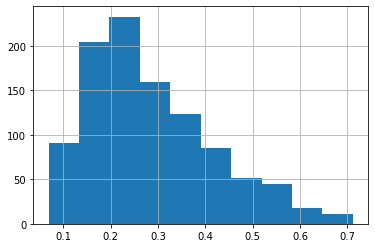

In [744]:
test_data["score"].hist()

In [716]:
test_data.to_csv("TrotsenkoDaniil_test.csv",index=None,columns=['id','score'])